# Explaining SIM City Mechanics

...with examples.

This notebook serves to illustrate how the environment calculates pollution / population gain for every tile. And how each city tile affects other city tile.

This is different from `eaxmple_run.ipynb` as this notebook has no agent involvement or even indicate how the simulation is run. This is strictly on the scoring system and how each tile affects each other.

In [85]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
#let's import our pre-requisites packages
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch, Rectangle

from environments.environment import CityModel
from update_rules.update_rules import DefaultUpdateRules, DefaultUpdateRulesParameters
from agents.agent import CityPlanner
from utils import TileTypes

In [87]:
list(TileTypes)[0]

<TileTypes.BARREN: 0>

In [88]:
tile_colours_map = {
    TileTypes.BARREN: "#eea5a5",
    TileTypes.RESIDENCE: "#ffeb3b",
    TileTypes.GREENERY: "#4caf50",
    TileTypes.INDUSTRY: "#9e9e9e",
    TileTypes.SERVICE: "#2196f3",
    TileTypes.ROAD: "#424242",
}

#in case I add any new tiles
assert(len(TileTypes)==len(tile_colours_map))

tile_colours = [tile_colours_map[t] for t in TileTypes]
tile_names = [t.name for t in TileTypes]

#visualise function that will be used here
def visulise_graph(model):
    #go go go AI chatbot

    # Fetch arrays
    tile = model.grid.tile._mesa_data
    pop_g = model.grid.pop_g._mesa_data
    poll_g = model.grid.poll_g._mesa_data

    # Discrete colormap setup for tile (ensure order is 0..max_type)
    max_type = max([t.value for t in TileTypes])
    color_list = [tile_colours_map.get(t, "#000000") for t in TileTypes]
    tile_cmap = ListedColormap(color_list)
    # Boundaries s.t. integers map cleanly to categories
    bounds = np.arange(-0.5, max_type + 1.5, 1)
    tile_norm = BoundaryNorm(bounds, tile_cmap.N)

    # Create figure and axes
    # Layout: 2 rows (1 for tile, 1 for pop_g/poll_g)
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

    ax_tile = fig.add_subplot(gs[0, :])
    im0 = ax_tile.imshow(tile, cmap=tile_cmap, norm=tile_norm, origin="upper", aspect="equal")
    ax_tile.set_title("Tile", fontsize=14)
    nx, ny = tile.shape
    ax_tile.set_xticks(np.arange(-0.5, ny, 1), minor=True)
    ax_tile.set_yticks(np.arange(-0.5, nx, 1), minor=True)
    ax_tile.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax_tile.tick_params(which="minor", bottom=False, left=False)
    ax_tile.set_xticks([])
    ax_tile.set_yticks([])

    # Build legend patches for tile types that actually appear
    legend_handles = [
        Patch(facecolor=tile_colours_map[t], edgecolor="none", label=t.name)
        for t in TileTypes
    ]
    ax_tile.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.12),
        ncol=len(legend_handles),  # one row
        frameon=False,
        title="Tile Types",
        fontsize=9,
        title_fontsize=10,
    )

    # --- Row 2: pop_g and poll_g ---
    ax_pop = fig.add_subplot(gs[1, 0])
    ax_poll = fig.add_subplot(gs[1, 1])

    # Population growth
    im1 = ax_pop.imshow(pop_g, cmap="viridis", origin="upper", aspect="equal")
    ax_pop.set_title("Population Growth (pop_g)", fontsize=12)
    ax_pop.set_xticks(np.arange(-0.5, pop_g.shape[0], 1), minor=True)
    ax_pop.set_yticks(np.arange(-0.5, pop_g.shape[1], 1), minor=True)
    ax_pop.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax_pop.tick_params(which="minor", bottom=False, left=False)
    ax_pop.set_xticks([])
    ax_pop.set_yticks([])
    fig.colorbar(im1, ax=ax_pop, shrink=0.85, label="pop_g")

    for i in range(pop_g.shape[0]):
        for j in range(pop_g.shape[1]):
            val = float(pop_g[i, j])
            if val>0:
                ax_pop.text(
                    j, i, f"{val:.1f}",
                    ha="center", va="center",
                    color="red", fontsize=8, fontweight="bold"
                )

    # Pollution growth
    im2 = ax_poll.imshow(poll_g, cmap="viridis", origin="upper", aspect="equal")
    ax_poll.set_title("Pollution Growth (poll_g)", fontsize=12)
    ax_poll.set_xticks(np.arange(-0.5, poll_g.shape[0], 1), minor=True)
    ax_poll.set_yticks(np.arange(-0.5, poll_g.shape[1], 1), minor=True)
    ax_poll.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax_poll.tick_params(which="minor", bottom=False, left=False)
    ax_poll.set_xticks([])
    ax_poll.set_yticks([])
    fig.colorbar(im2, ax=ax_poll, shrink=0.85, label="poll_g")
    for i in range(poll_g.shape[0]):
        for j in range(poll_g.shape[1]):
            val = float(poll_g[i, j])
            if val>0:
                ax_poll.text(
                    j, i, f"{val:.1f}",
                    ha="center", va="center",
                    color="red", fontsize=8, fontweight="bold"
                )
    plt.tight_layout()
    plt.show()

def visualise_road_tiles(model):
    #go go go AI chatbot
    road_sets = model.road_sets
    nrows, ncols = road_sets.shape
    font_min=6; font_max=16
    base = min( max( int(min(nrows, ncols) and 36 / max(nrows, ncols) * 10), font_min), font_max )

    fig_w = min(18, max(6, ncols * 0.5))
    fig_h = min(18, max(4, nrows * 0.5))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    
    ax.set_title("Road sets", fontsize=base+2)
    # Draw cells as empty white rectangles with black borders
    ax.set_xlim(-0.5, ncols - 0.5)
    ax.set_ylim(nrows - 0.5, -0.5)  # origin='upper' to match NumPy [row, col]
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    # Cell borders
    for i in range(nrows):
        for j in range(ncols):
            ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="black", linewidth=0.6))

    # Text overlay (numbers only)
    for i in range(nrows):
        for j in range(ncols):
            v = road_sets[i, j]
            if v<=0:
                continue
            s = "nan" if np.isnan(v) else int(v)
            ax.text(j, i, s, ha="center", va="center", color="red", fontsize=base, fontweight="bold")

    plt.tight_layout()
    plt.show()

In [89]:
#let's create our environment first
with open("data/update_parameters/DefaultUpdateRule.json") as f:
    default_rule_parameters = json.load(f)
    
default_rule_parameters = DefaultUpdateRulesParameters(**default_rule_parameters)

# define the class with empty parameters and set the parameters thereafter. 
# In case for extensions, one can override the parameters
update_rules = DefaultUpdateRules()
update_rules.set_parameters(default_rule_parameters)

#shouldn't do this but since we are not using any agent in the first place
width = 16
height = 16
model = CityModel(CityPlanner, width, height, update_rules, collect_rate=1.0)

## The Basics

We want to do urban planning with sustainability in mind. To this mind, we have an urban city discretised into a grid. For each turn, we will place a city tile on the grid, depending on the type of tile, it will produce pollution and/or population. The objective is to maximise population, and minimise pollution.

In the beginning, we have nothing but Barren land which produces 0 pollution and population.

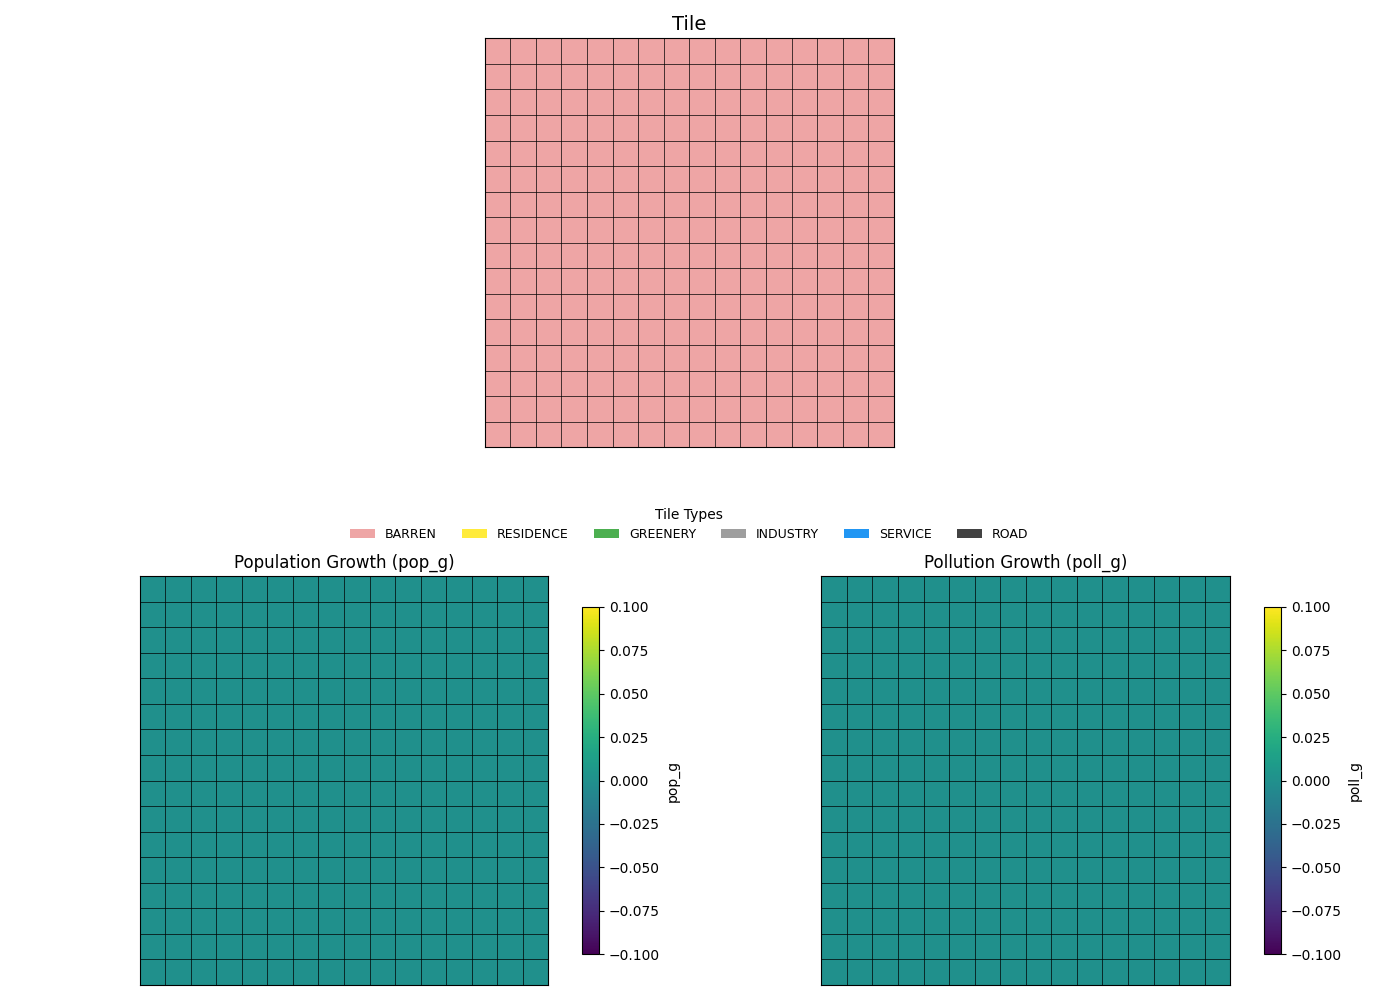

In [90]:
visulise_graph(model)

## Residence 

Residence tile represents liveability of a city. They produce population and pollution, their main function is to increase the population cap of the city. If your population cap is too low, the total population will be capped. Let's add some residence tiles around.

Note in the simulation, each tile is placed at a time.

In [91]:
model.set_tile(2, 3,TileTypes.RESIDENCE.value)
model.set_tile(5, 12,TileTypes.RESIDENCE.value)
model.set_tile(12, 2,TileTypes.RESIDENCE.value)
model.set_tile(10, 10,TileTypes.RESIDENCE.value)
model.set_tile(7, 6,TileTypes.RESIDENCE.value)

#this method must be invoked as it will consolidate the different tiles into seperate binary 
#numpy array
model.book_keep()

# we will need to invoke the update rules to update the population / pollution gain
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)
print(f"Current Population cap: {population_cap}")

5
Current Population cap: 50


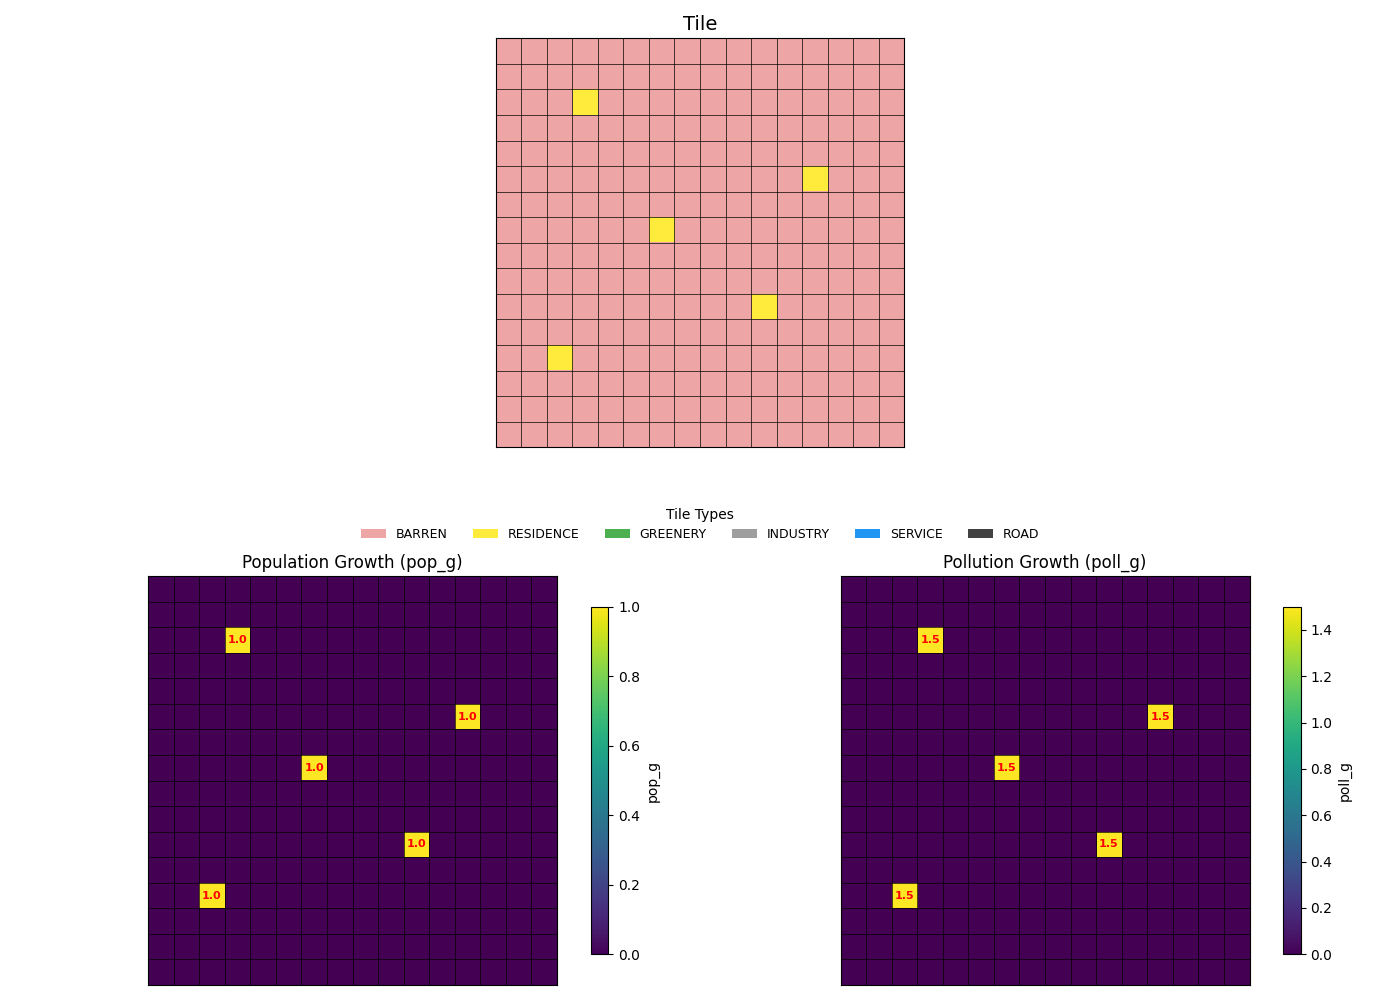

In [92]:
visulise_graph(model)

## Road

Road represent amenities and connectivity within the city. Roads don't produce much population but it produces quite a bit pollution. The main function of the road is to connect Residence tiles to Service and Industry tiles. Road tiles are connected only via top, bottom, left and right neighbours (not adjacent). Each connected road tiles will form a network, it is possible to have different networks.

In [93]:
# let's add some preliminary network

model.set_tile(12, 6,TileTypes.ROAD.value)
model.set_tile(12, 5,TileTypes.ROAD.value)
model.set_tile(12, 4,TileTypes.ROAD.value)
model.set_tile(12, 3,TileTypes.ROAD.value)
model.set_tile(10, 8,TileTypes.ROAD.value)
model.set_tile(10, 7,TileTypes.ROAD.value)
model.set_tile(10, 6,TileTypes.ROAD.value)
model.set_tile(9, 6,TileTypes.ROAD.value)
model.set_tile(8, 10,TileTypes.ROAD.value)
model.set_tile(8, 11,TileTypes.ROAD.value)
model.set_tile(8, 12,TileTypes.ROAD.value)
model.set_tile(8, 13,TileTypes.ROAD.value)
model.set_tile(7, 14,TileTypes.ROAD.value)
model.set_tile(6, 14,TileTypes.ROAD.value)
model.set_tile(5, 14,TileTypes.ROAD.value)
model.set_tile(4, 14,TileTypes.ROAD.value)
model.set_tile(3, 8,TileTypes.ROAD.value)
model.set_tile(2, 8,TileTypes.ROAD.value)
model.set_tile(2, 7,TileTypes.ROAD.value)
model.set_tile(2, 6,TileTypes.ROAD.value)
model.set_tile(2, 5,TileTypes.ROAD.value)
model.set_tile(2, 4,TileTypes.ROAD.value)

model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

5


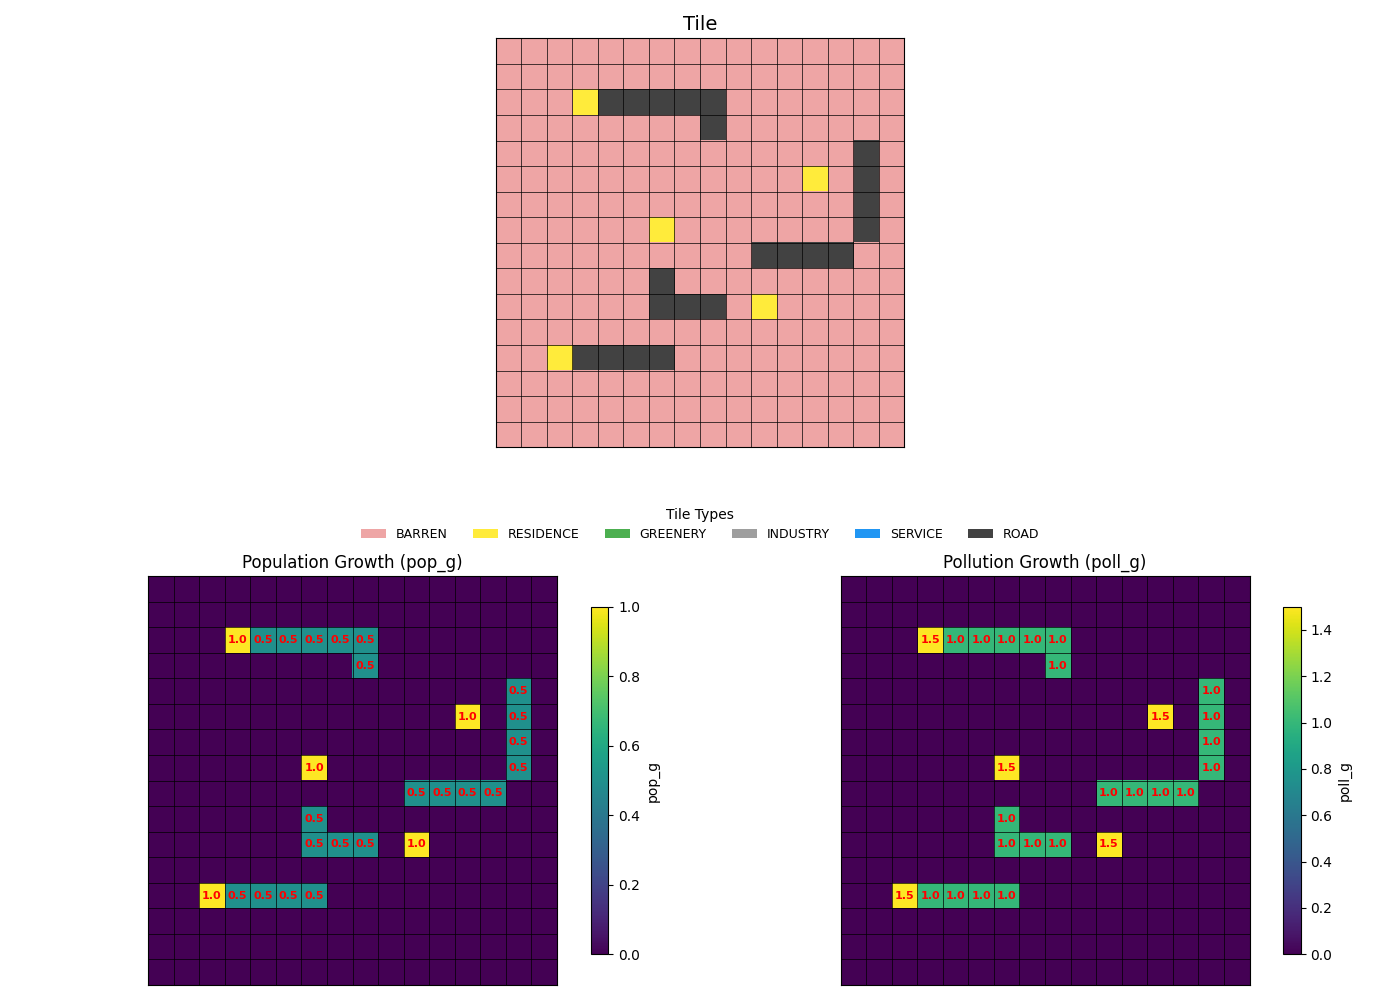

In [94]:
visulise_graph(model)

We can also visualise its road "network" as well. Network in quotes because it's really more of assigning ids to each road tiles. Tile with the same id belongs to the same network. You will note that roads that are diagonal to each other are not counted (Road network 3 and 4)

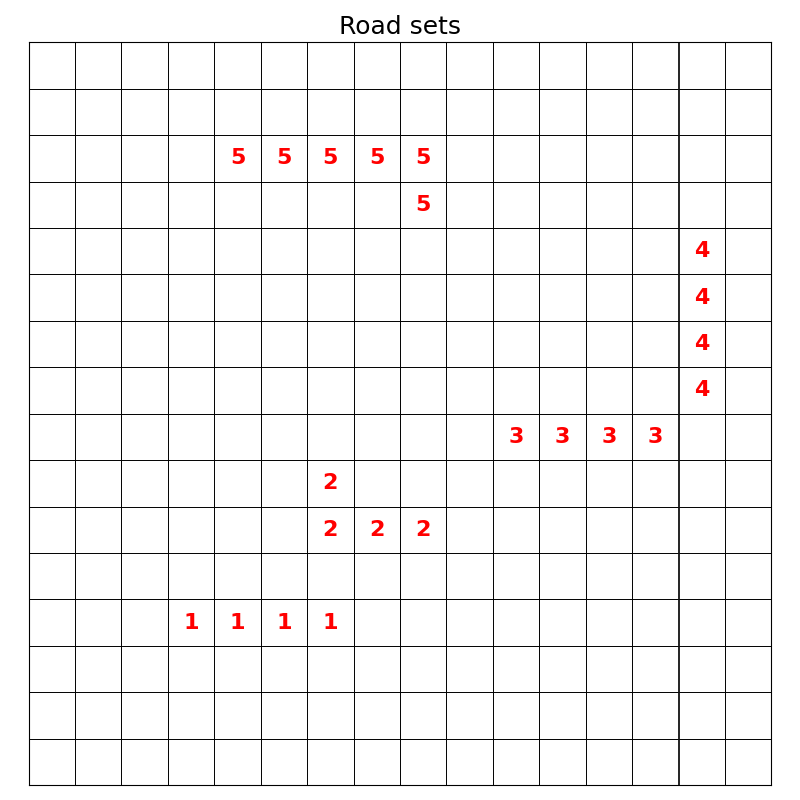

In [95]:
visualise_road_tiles(model)

Road networks can be merged. Smaller networks are subsumed into bigger network. Let's first add one more road time to network 4. Then merge 3 and 4 together

5


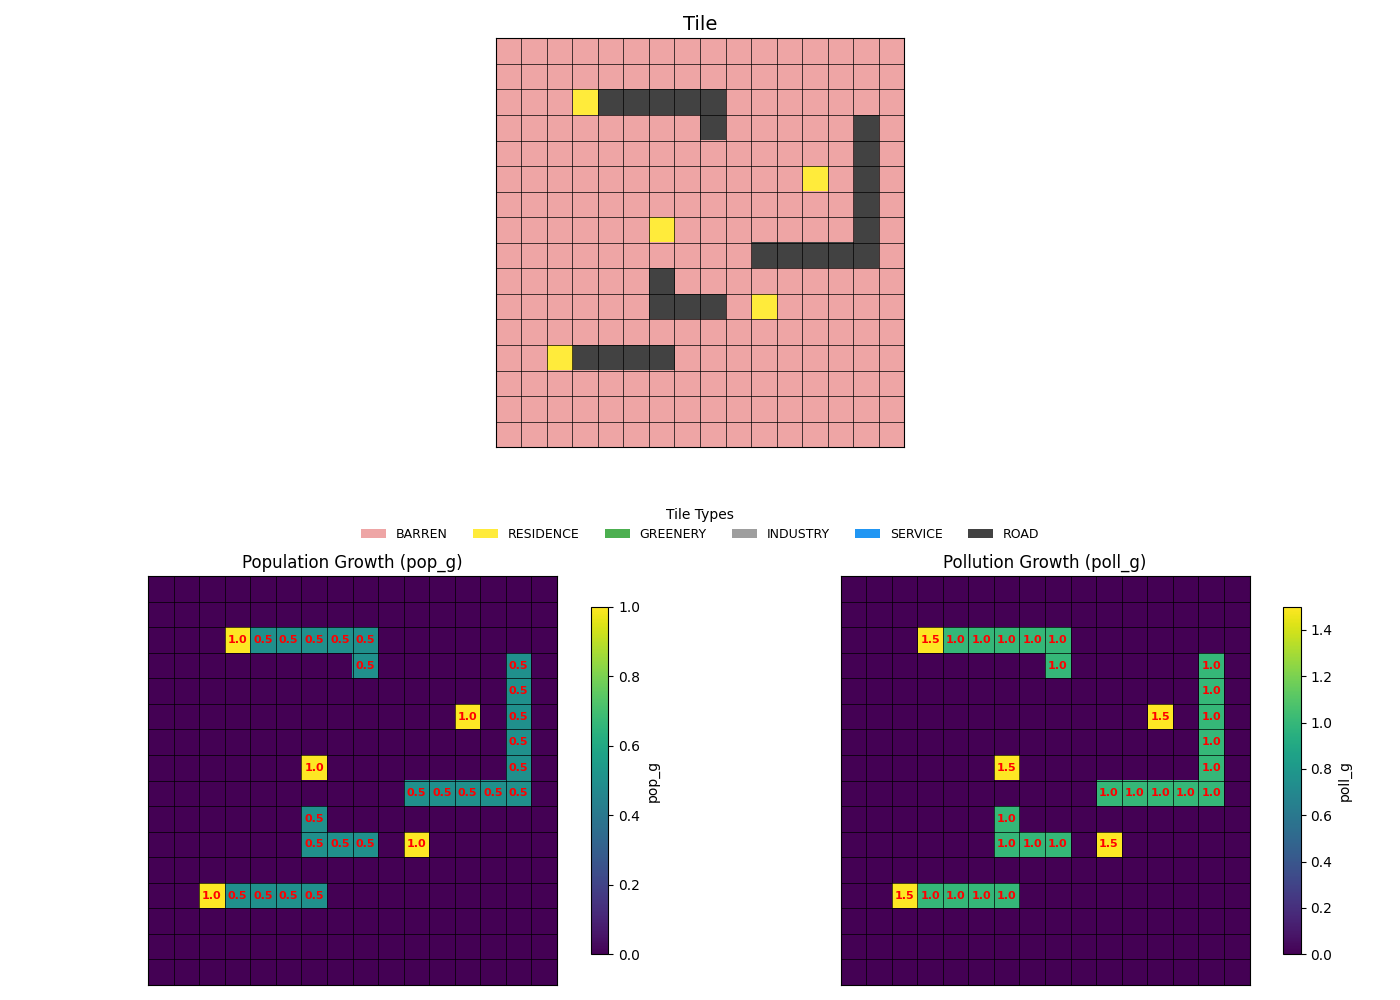

In [96]:
model.set_tile(3, 14,TileTypes.ROAD.value)
model.set_tile(8, 14,TileTypes.ROAD.value)

model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

visulise_graph(model)

Visualising the road IDs, we can see that 3 is gone and merged into 4 as it has more road tiles.

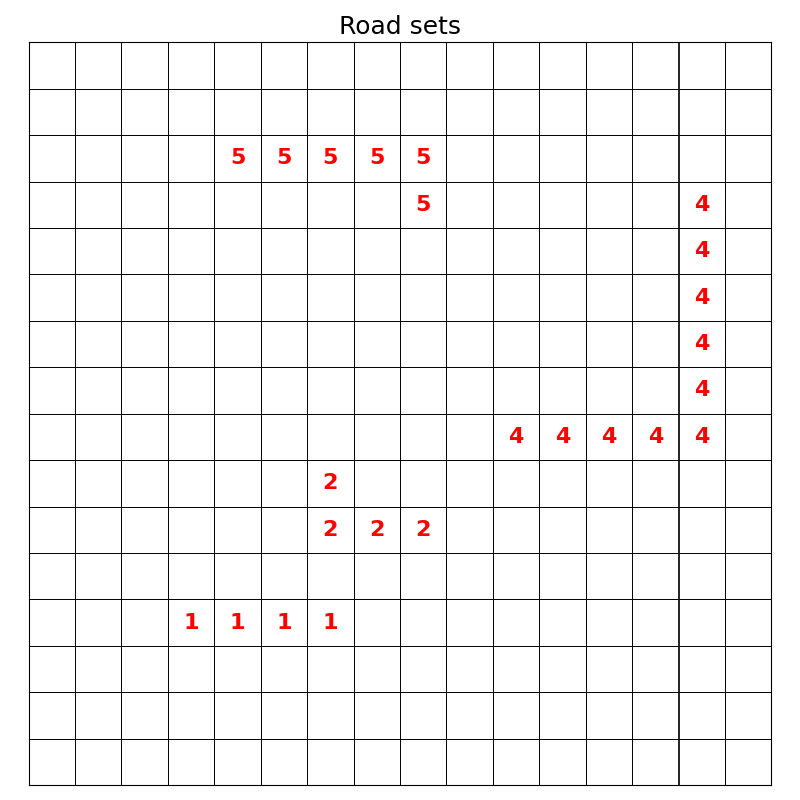

In [97]:
visualise_road_tiles(model)

### Residence and Roads

Under the hood, the environment will keep track which Residence tiles are connected to which Road network. During merging, residences are also connected